# AIRLINE SEARCH FARE PREDICTION

### Airline pricing is one of the most complex problems in the industry and varies on various factors. Pricing too high will result in lesser passengers and too low will result in loss. It needs to take into account competitors pricing as well on the same market.
### Predicting the of price for a given departure week in different search weeks will help in competitor study and also helps in demand and revenue forecasting.
### This exercise aims to predict the price of a ticket of an airline based on features such as search date, departure date, origin, destination, no. of passengers, cabin class, airline etc.
### We use a a Stacking Method where a second model is trained based on the output of many models such as Random Forest, XGBoost, LightGBM and the final result is predicted by this stacked model.

#### NOTE:
- The orign, destination, airline, currency, aircraft, country are encoded to maintain confidentiality of the data. As these are categorical, the encoding in no way affects the working of the model. It only masks the actual categories these columns represents.
- The price column in present in different currencies. The output should also be in the currencies present in test dataset. But we convert all prices to a single currency, build the model and then convert back to respective currencies.
- We use MAPE as the evalation metric.

In [1]:
from IPython.core.display import display, HTML
display(HTML(
    "<style>.container { width:95% !important; } .dataframe td {white-space: nowrap; } </style>"))
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
# import statements
import math
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import mean_absolute_percentage_error

%matplotlib inline
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', 150)

import warnings
warnings.filterwarnings('ignore')

In [3]:
daily_currency_df = pd.DataFrame([[20181130, 1, 69.7196, 1.3676, 7.8237, 0.8835, 1120.4518],
                                  [20181201, 1, 69.6475, 1.3672, 7.8236, 0.8833, 1120.4560],
                                  [20181202, 1, 69.7703, 1.3569, 7.8228, 0.8818, 1118.4047],
                                  [20181204, 1, 70.6403, 1.3617, 7.8032, 0.8815, 1111.5736],
                                  [20181205, 1, 70.6525, 1.3774, 7.8142, 0.8813, 1112.7467],
                                  [20181206, 1, 70.5635, 1.3829, 7.8112, 0.8791, 1120.5888],
                                  [20181207, 1, 71.3751, 1.3874, 7.8162, 0.8784, 1125.6013],
                                  [20181209, 1, 71.3722, 1.3915, 7.8158, 0.8768, 1123.1662],
                                  [20181210, 1, 72.5164, 1.3903, 7.8142, 0.8805, 1132.4501],
                                  [20181211, 1, 72.3328, 1.3862, 7.8167, 0.8832, 1128.6821],
                                  [20181212, 1, 71.8411, 1.3852, 7.8150, 0.8793, 1124.8665],
                                  [20181213, 1, 71.5275, 1.3842, 7.8125, 0.8802, 1128.0560],
                                  [20181214, 1, 71.9639, 1.3930, 7.8128, 0.8843, 1132.6887],
                                  [20181216, 1, 71.9222, 1.3936, 7.8124, 0.8844, 1132.4548],
                                  [20181217, 1, 71.5933, 1.3930, 7.8125, 0.8810, 1129.0931],
                                  [20181218, 1, 70.4942, 1.3916, 7.8201, 0.8791, 1126.1628],
                                  [20181219, 1, 70.6956, 1.4058, 7.8264, 0.8782, 1129.2191],
                                  [20181220, 1, 70.0890, 1.4046, 7.8287, 0.8729, 1121.1959],
                                  [20181221, 1, 70.1410, 1.4208, 7.8327, 0.8795, 1127.5052],
                                  [20181224, 1, 70.1207, 1.4197, 7.8345, 0.8772, 1124.0257],
                                  [20181225, 1, 70.1241, 1.4191, 7.8323, 0.8759, 1123.6304],
                                  [20181226, 1, 70.1549, 1.4134, 7.8287, 0.8803, 1123.5167],
                                  [20181227, 1, 69.9969, 1.4216, 7.8319, 0.8747, 1120.9643],
                                  [20181229, 1, 69.9250, 1.4196, 7.8309, 0.8741, 1117.3679],
                                  [20181230, 1, 69.9125, 1.4191, 7.8320, 0.8742, 1117.3188],
                                  [20181231, 1, 69.5661, 1.4205, 7.8309, 0.8702, 1113.4550],
                                 ],
                                 columns=['search_date', 'F', 'D', 'A', 'C', 'B', 'E'])
daily_currency_df = daily_currency_df.melt(id_vars=['search_date'], value_vars=['F', 'D', 'A', 'C', 'B', 'E'],
                                           var_name='currency', value_name='conversion_rate_daily')
daily_currency_df['search_date'] = pd.to_datetime(daily_currency_df['search_date'], format='%Y%m%d')
daily_currency_df.head()


,search_date,currency,conversion_rate_daily
0,2018-11-30,F,1.0
1,2018-12-01,F,1.0
2,2018-12-02,F,1.0
3,2018-12-04,F,1.0
4,2018-12-05,F,1.0


In [4]:
def build_features(df):
    """
    Feature Engineering with the help of existing columns

    Args:
        df (str): Dataframe to be enriched.

    Returns:
        DataFrame. The enriched dataframe with new features
    """
    df = df.copy(deep=True)
    # Extract date related features wrt booking date.
    df['search_date_int'] = df['search_date'].dt.strftime('%Y%m%d').astype(int)
    df['search_date_days'] = np.where(df['search_date_int'] == 20181130, 0, df['search_date_int'] - 20181200)
    df['search_week_day'] = df['search_date'].dt.weekday
    df['search_month_day'] = df['search_date'].dt.day

    # Extract time and date related features wrt departure date.
    df['departure_date_time'] = df['departure_date'].astype('int64')//1e9
    df['departure_date_days'] = ((df['departure_date_time'] - 1543536000)//86400).astype('int32')
    df['departure_week_day'] = df['departure_date'].dt.weekday
    df['departure_month_day'] = df['departure_date'].dt.day
    df['departure_month'] = df['departure_date'].dt.month
    df['departure_time_str'] =  df['departure_time'].astype(str).str.zfill(4)
    df['departure_hour'] = df['departure_time_str'].str[:2].astype(int)
    # Introduce sine and cosine components as 00:00 and 23:00 hrs are close to each other.
    # Without this cyclic representation, they will be far apart in linear representation.
    df['departure_hour_sine'] = np.sin(2 * math.pi * (df['departure_hour'] / 23))
    df['departure_cosine'] = np.cos(2 * math.pi * (df['departure_hour'] / 23))
    df['departure_time_min'] = (df['departure_time_str'].str[:2].astype(int) * 60) + (df['departure_time_str'].str[2:].astype(int))
    df['departure_time_slot'] = df['departure_time_min'] // 360

    # Predict the arrival time based on total flight time
    df['travel_time'] = (df['eft'] * 60).astype(int)
    df['arrival_time_min'] = df['departure_time_min'] + df['travel_time']
    df['next_day_arrival'] = np.where(df['arrival_time_min'] > 1440, 1, 0)
    df['arrival_time_min'] = np.where(df['arrival_time_min'] > 1440, df['arrival_time_min'] % 1440, df['arrival_time_min'])
    df['arrival_time_slot'] = df['arrival_time_min'] // 360

    # Speed of the aircraft
    df['od'] = df['origin'].astype(str) + '-' + df['destination'].astype(str)
    df['speed'] = df['distance'] / df['eft']
    # Segment into Low Cost Carries(LCCs) vs Full Service Carries
    # This is based on domain knowledge. Also, airlines are encoded and might not make sense here.
    # But, I know the mapping and have made sure to map them correctly into LCCs
    df['lcc'] = np.where(df['carrier'].isin(['C', 'E']), 1, 0)
    df['aircraft_yield'] = np.where(df['aircraft'].isin(['G', 'K']), 'aH',
                                          np.where(df['aircraft'].isin(['D', 'E', 'F', 'J']), 'aL', 'aM'))

    # Price related adjustments
    df['price_per_passenger'] = df['price'] / df['number_of_passengers']
    df = df.merge(daily_currency_df, on=['search_date', 'currency'], how='left')
    df['price_per_passenger_usd'] = df['price_per_passenger'] / df['conversion_rate_daily']
    # A new metric which gives revenue per kilometer per passenger
    df['yield'] = df['price_per_passenger_usd'] / df['distance']

    return df



#### price represents the dependent variable and all other columns are independent features

In [5]:
df_train = pd.read_csv('train_encoded.csv', sep='^', parse_dates=['search_date', 'departure_date'], infer_datetime_format=True)
df_train.shape
df_train.head()

(100000, 18)

,id,search_date,origin,destination,distance,departure_date,departure_time,departure_day_of_week,advance_purchase,eft,carrier,cabin,rbd,aircraft,number_of_passengers,country,currency,price
0,1,2018-12-12,B,M,1390,2018-12-30,705,Sun,18,2.850,F,M,N,H,2,H,F,328.4
1,2,2018-12-25,J,I,380,2018-12-26,1455,Wed,1,1.250,B,M,H,F,2,C,B,287.3
2,3,2018-12-20,H,F,1723,2019-01-12,2132,Sat,23,3.117,C,M,P,C,3,H,F,270.6
3,4,2018-12-09,O,P,1093,2018-12-13,950,Thu,4,2.267,B,M,B,F,1,A,A,409.0
4,5,2018-12-31,P,J,543,2019-01-08,835,Tue,8,1.717,A,M,L,K,2,A,A,909.4


## EDA

#### We see that there are no missing values. Just to make sure, we check unique values for categories and see that they don't represent any misisng values such as '?' or '-'

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   id                     100000 non-null  int64         
 1   search_date            100000 non-null  datetime64[ns]
 2   origin                 100000 non-null  object        
 3   destination            100000 non-null  object        
 4   distance               100000 non-null  int64         
 5   departure_date         100000 non-null  datetime64[ns]
 6   departure_time         100000 non-null  int64         
 7   departure_day_of_week  100000 non-null  object        
 8   advance_purchase       100000 non-null  int64         
 9   eft                    100000 non-null  float64       
 10  carrier                100000 non-null  object        
 11  cabin                  100000 non-null  object        
 12  rbd                    100000 non-null  objec

#### All the categorical variables are encoded to maintain confidentiality

In [7]:
cat_cols = df_train.select_dtypes(include='object').columns.to_list()
for col in cat_cols:
    print(f"Unique categories in {col}: {df_train[col].unique()}")
df_train[cat_cols] = df_train[cat_cols].astype('category')

Unique categories in origin: ['B' 'J' 'H' 'O' 'P' 'M' 'K' 'L' 'G' 'E' 'I' 'F' 'A' 'N' 'C' 'D']
Unique categories in destination: ['M' 'I' 'F' 'P' 'J' 'O' 'L' 'B' 'A' 'E' 'K' 'C' 'H' 'D']
Unique categories in departure_day_of_week: ['Sun' 'Wed' 'Sat' 'Thu' 'Tue' 'Fri' 'Mon']
Unique categories in carrier: ['F' 'B' 'C' 'A' 'D' 'E']
Unique categories in cabin: ['M' 'F']
Unique categories in rbd: ['N' 'H' 'P' 'B' 'L' 'O' 'W' 'R' 'E' 'K' 'V' 'U' 'Y' 'X' 'Q' 'G' 'M' 'I'
 'J' 'S' 'C' 'Z' 'T' 'A' 'F' 'D']
Unique categories in aircraft: ['H' 'F' 'C' 'K' 'I' 'J' 'G' 'B' 'E' 'D' 'A']
Unique categories in country: ['H' 'C' 'A' 'G' 'D' 'E' 'F' 'B']
Unique categories in currency: ['F' 'B' 'A' 'C' 'D' 'E']


In [8]:
df_train.describe(include='all')

,id,search_date,origin,destination,distance,departure_date,departure_time,departure_day_of_week,advance_purchase,eft,carrier,cabin,rbd,aircraft,number_of_passengers,country,currency,price
count,100000.000000,100000,100000,100000,100000.000000,100000,100000.000000,100000,100000.000000,100000.000000,100000,100000,100000,100000,100000.00000,100000,100000,1.000000e+05
unique,NaN,26,16,14,NaN,308,NaN,7,NaN,NaN,6,2,26,11,NaN,8,6,NaN
top,NaN,2018-12-01 00:00:00,J,J,NaN,2018-12-28 00:00:00,NaN,Sun,NaN,NaN,F,M,B,F,NaN,H,F,NaN
freq,NaN,11827,16947,18459,NaN,2932,NaN,16672,NaN,NaN,22826,97244,10361,19706,NaN,56873,56873,NaN
first,NaN,2018-11-30 00:00:00,NaN,NaN,NaN,2018-12-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,2018-12-31 00:00:00,NaN,NaN,NaN,2019-11-25 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,50000.500000,NaN,NaN,NaN,1942.185510,NaN,1355.134680,NaN,32.282610,3.284765,NaN,NaN,NaN,NaN,1.79017,NaN,NaN,1.314797e+04
std,28867.657797,NaN,NaN,NaN,1231.382088,NaN,515.119594,NaN,38.208828,1.611331,NaN,NaN,NaN,NaN,1.08896,NaN,NaN,7.014506e+04
min,1.000000,NaN,NaN,NaN,286.000000,NaN,5.000000,NaN,0.000000,0.983000,NaN,NaN,NaN,NaN,1.00000,NaN,NaN,3.394000e+01
25%,25000.750000,NaN,NaN,NaN,1032.000000,NaN,905.000000,NaN,8.000000,2.033000,NaN,NaN,NaN,NaN,1.00000,NaN,NaN,2.024000e+02


In [9]:
# Extract some relevent features from available columns

df_train = build_features(df_train)
df_train.shape
df_train.head()

(100000, 45)

,id,search_date,origin,destination,distance,departure_date,departure_time,departure_day_of_week,advance_purchase,eft,carrier,cabin,rbd,aircraft,number_of_passengers,country,currency,price,search_date_int,search_date_days,search_week_day,search_month_day,departure_date_time,departure_date_days,departure_week_day,departure_month_day,departure_month,departure_time_str,departure_hour,departure_hour_sine,departure_cosine,departure_time_min,departure_time_slot,travel_time,arrival_time_min,next_day_arrival,arrival_time_slot,od,speed,lcc,aircraft_yield,price_per_passenger,conversion_rate_daily,price_per_passenger_usd,yield
0,1,2018-12-12,B,M,1390,2018-12-30,705,Sun,18,2.850,F,M,N,H,2,H,F,328.4,20181212,12,2,12,1.546128e+09,30,6,30,12,0705,7,0.942261,-0.334880,425,1,171,596,0,1,B-M,487.719298,0,aM,164.20,1.0000,164.200000,0.118129
1,2,2018-12-25,J,I,380,2018-12-26,1455,Wed,1,1.250,B,M,H,F,2,C,B,287.3,20181225,25,1,25,1.545782e+09,26,2,26,12,1455,14,-0.631088,-0.775711,895,2,75,970,0,2,J-I,304.000000,0,aL,143.65,0.8759,164.002740,0.431586
2,3,2018-12-20,H,F,1723,2019-01-12,2132,Sat,23,3.117,C,M,P,C,3,H,F,270.6,20181220,20,3,20,1.547251e+09,43,5,12,1,2132,21,-0.519584,0.854419,1292,3,187,39,1,0,H-F,552.775104,1,aM,90.20,1.0000,90.200000,0.052351
3,4,2018-12-09,O,P,1093,2018-12-13,950,Thu,4,2.267,B,M,B,F,1,A,A,409.0,20181209,9,6,9,1.544659e+09,13,3,13,12,0950,9,0.631088,-0.775711,590,1,136,726,0,2,O-P,482.134980,0,aL,409.00,1.3915,293.927416,0.268918
4,5,2018-12-31,P,J,543,2019-01-08,835,Tue,8,1.717,A,M,L,K,2,A,A,909.4,20181231,31,0,31,1.546906e+09,39,1,8,1,0835,8,0.816970,-0.576680,515,1,103,618,0,1,P-J,316.249272,0,aH,454.70,1.4205,320.098557,0.589500


## Visual Analysis

### Univariate visualization of some numerical columns

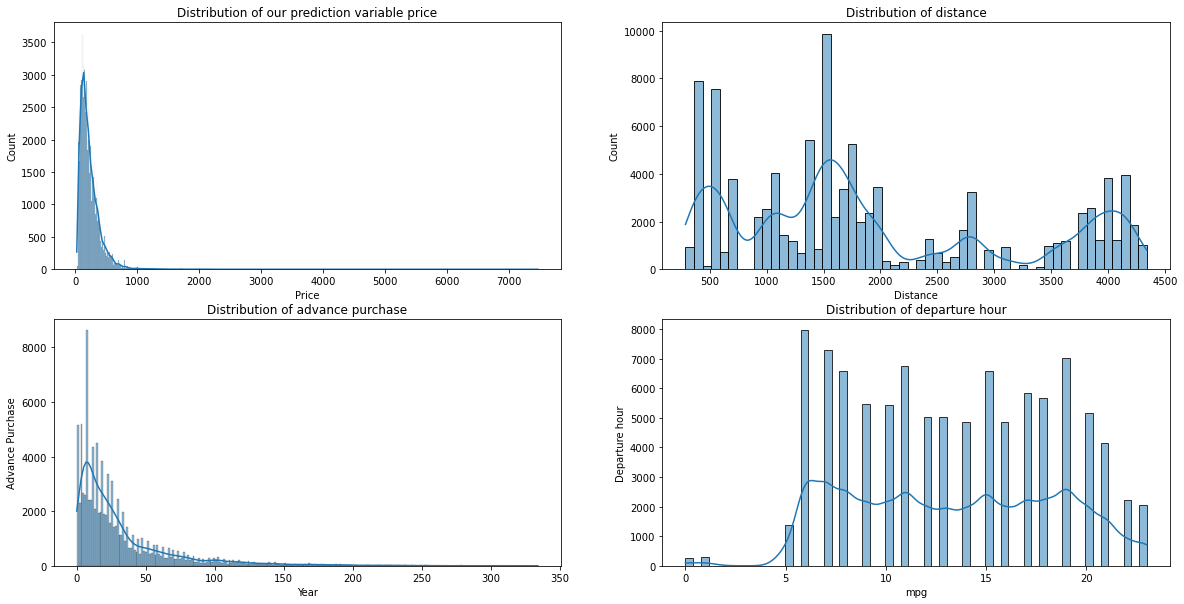

In [10]:
fig, ax = plt.subplots(2, 2, figsize=(20, 10))

_ = sns.histplot(x='price_per_passenger_usd', data=df_train, kde=True, ax=ax[0][0])
_ = ax[0][0].set_xlabel('Price')
_ = ax[0][0].set_ylabel('Count')
_ = ax[0][0].set_title('Distribution of our prediction variable price')

_ = sns.histplot(x='distance', data=df_train, kde=True, ax=ax[0][1])
_ = ax[0][1].set_xlabel('Distance')
_ = ax[0][1].set_ylabel('Count')
_ = ax[0][1].set_title('Distribution of distance')

_ = sns.histplot(x='advance_purchase', data=df_train, kde=True, ax=ax[1][0])
_ = ax[1][0].set_xlabel('Year')
_ = ax[1][0].set_ylabel('Advance Purchase')
_ = ax[1][0].set_title('Distribution of advance purchase')

_ = sns.histplot(x='departure_hour', data=df_train, kde=True, ax=ax[1][1])
_ = ax[1][1].set_xlabel('mpg')
_ = ax[1][1].set_ylabel('Departure hour')
_ = ax[1][1].set_title('Distribution of departure hour')

In [11]:
### As we can see, our prediction variable, price_per_passenger_usd is heavily right skewed. Hence we can use log normalization on this column or remove the outliers
### Advance purchase is also right skewed, meaning more people tend to book closer to departure date
### Departure hour seems to have uniform distribution and distance seems to be bi-modal

In [12]:
# df_train = df_train.loc[df_train['price_per_passenger_usd'] < 2000]
df_train['log2_price_per_passenger_usd'] = np.log2(df_train['price_per_passenger_usd'])


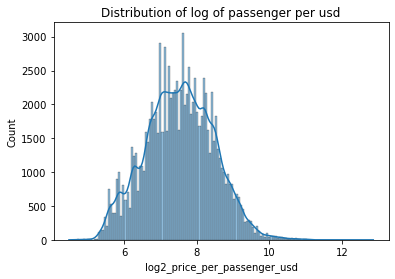

In [13]:
g = sns.histplot(x='log2_price_per_passenger_usd', data=df_train, kde=True)
_ = g.set_title('Distribution of log of passenger per usd')


### Pairplot of price wrt some important features

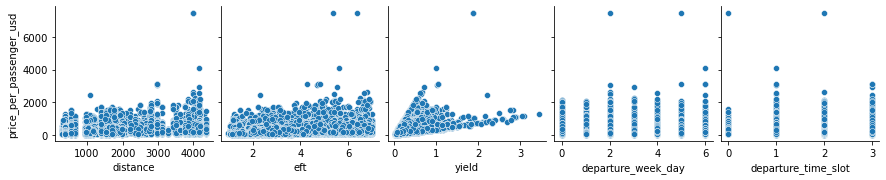

In [14]:
_ = sns.pairplot(df_train, x_vars=['distance', 'eft', 'yield', 'departure_week_day', 'departure_time_slot'], y_vars=['price_per_passenger_usd'])

In [15]:
## Distance and time seem to have some direct correlation with price
## Fridays and Sundays seem to have higher prices compared to other days
## Morning and Night slots also have higher price compared to afternoon and early morning

### Violinplots of some categorical features

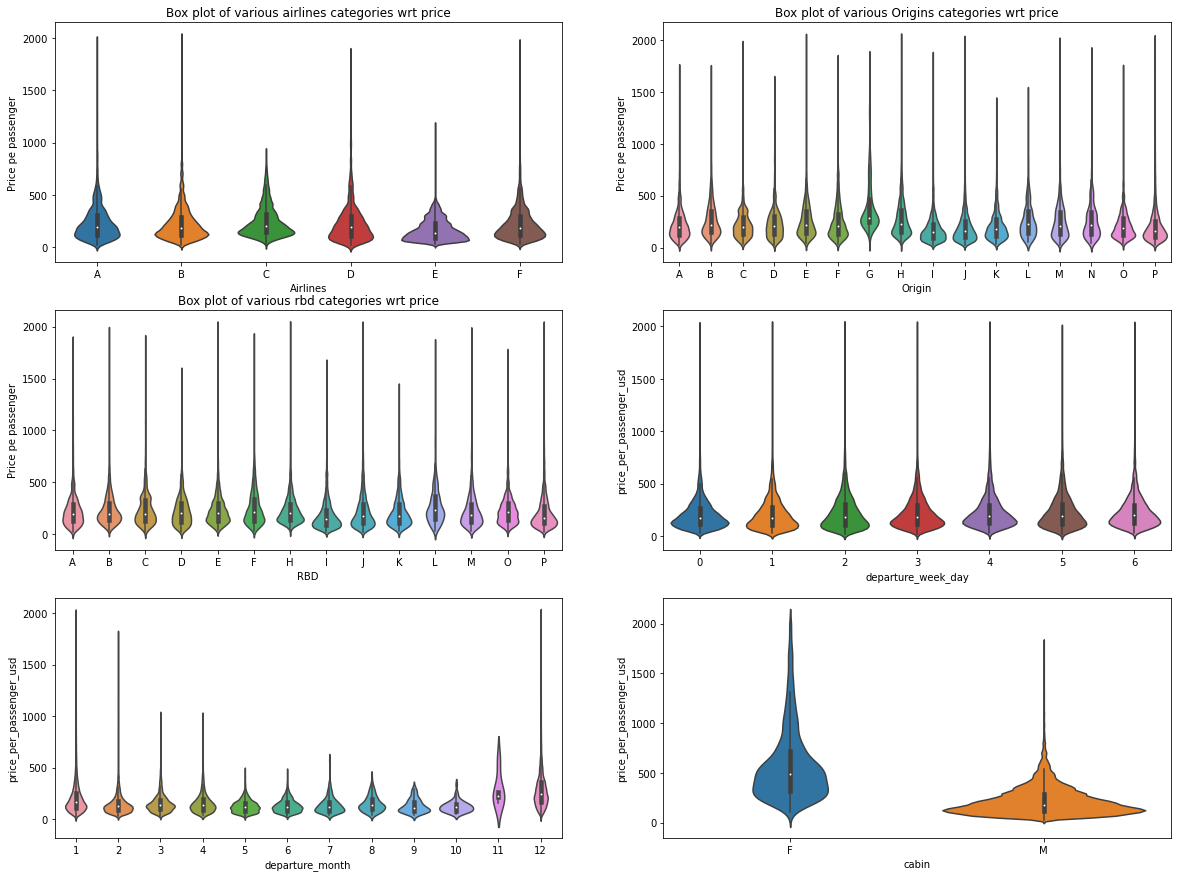

In [16]:
fig, ax = plt.subplots(3, 2, figsize=(20, 15), sharey=False)
df_train_without_outlier = df_train.loc[df_train['price_per_passenger_usd'] < 2000]

_ = sns.violinplot(x='carrier', y='price_per_passenger_usd', data=df_train_without_outlier, ax=ax[0][0], sym='')
_ = ax[0][0].set_xlabel('Airlines')
_ = ax[0][0].set_ylabel('Price pe passenger')
_ = ax[0][0].set_title('Box plot of various airlines categories wrt price')

_ = sns.violinplot(x='origin', y='price_per_passenger_usd', data=df_train_without_outlier, ax=ax[0][1], sym='')
_ = ax[0][1].set_xlabel('Origin')
_ = ax[0][1].set_ylabel('Price pe passenger')
_ = ax[0][1].set_title('Box plot of various Origins categories wrt price')

_ = sns.violinplot(x='destination', y='price_per_passenger_usd',  data=df_train_without_outlier, ax=ax[1][0], sym='')
_ = ax[1][0].set_xlabel('Destination')
_ = ax[1][0].set_ylabel('Price pe passenger')
_ = ax[1][0].set_title('Box plot of various Destinations categories wrt price')

_ = sns.violinplot(x='departure_week_day', y='price_per_passenger_usd',  data=df_train_without_outlier, ax=ax[1][1], sym='')
_ = ax[1][0].set_xlabel('Deprture Weekday')
_ = ax[1][0].set_ylabel('Price pe passenger')
_ = ax[1][0].set_title('Box plot of various weekdays categories wrt price')


_ = sns.violinplot(x='departure_month', y='price_per_passenger_usd',  data=df_train_without_outlier, ax=ax[2][0], sym='')
_ = ax[1][0].set_xlabel('Deprture Month')
_ = ax[1][0].set_ylabel('Price pe passenger')
_ = ax[1][0].set_title('Box plot of various months wrt price')

_ = sns.violinplot(x='cabin', y='price_per_passenger_usd',  data=df_train_without_outlier, ax=ax[2][1], sym='')
_ = ax[1][0].set_xlabel('RBD')
_ = ax[1][0].set_ylabel('Price pe passenger')
_ = ax[1][0].set_title('Box plot of various rbd categories wrt price')

In [17]:
### Airline C and E were assumed to be LCCs based on domain knowledge and is confirmed by the plot.
### Origin and destinations do not seem to have wild changes within the categories.
### RBDs and Cabin classes play an important role as expected.

### Heatmap wrt to numerical components

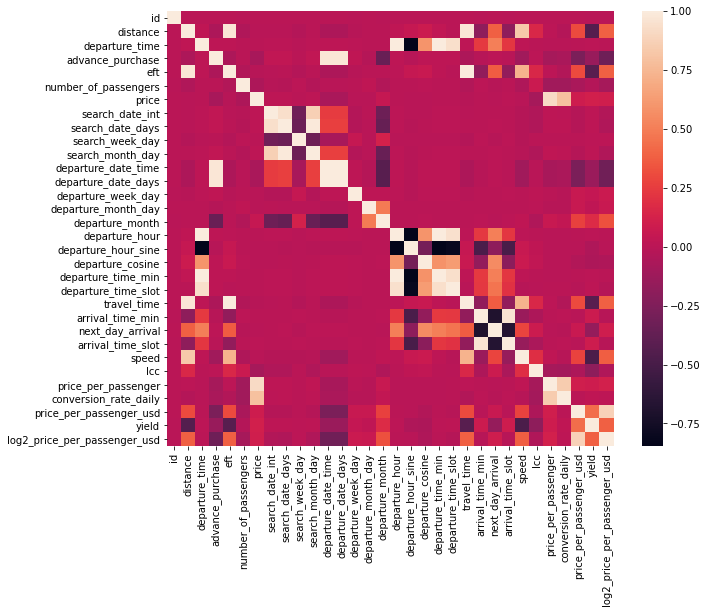

In [18]:
fig, ax = plt.subplots(figsize=(10,8))
_ = sns.heatmap(df_train.corr(), ax=ax)

### One hot encode the categorical variables

In [19]:
df_train = pd.get_dummies(df_train, columns=['origin', 'destination', 'carrier', 'cabin', 'rbd', 'aircraft', 'departure_week_day'], drop_first=True)
df_train.shape
df_train.head()

(100000, 114)

,id,search_date,distance,departure_date,departure_time,departure_day_of_week,advance_purchase,eft,number_of_passengers,country,currency,price,search_date_int,search_date_days,search_week_day,search_month_day,departure_date_time,departure_date_days,departure_month_day,departure_month,departure_time_str,departure_hour,departure_hour_sine,departure_cosine,departure_time_min,departure_time_slot,travel_time,arrival_time_min,next_day_arrival,arrival_time_slot,od,speed,lcc,aircraft_yield,price_per_passenger,conversion_rate_daily,price_per_passenger_usd,yield,log2_price_per_passenger_usd,origin_B,origin_C,origin_D,origin_E,origin_F,origin_G,origin_H,origin_I,origin_J,origin_K,origin_L,origin_M,origin_N,origin_O,origin_P,destination_B,destination_C,destination_D,destination_E,destination_F,destination_H,destination_I,destination_J,destination_K,destination_L,destination_M,destination_O,destination_P,carrier_B,carrier_C,carrier_D,carrier_E,carrier_F,cabin_M,rbd_B,rbd_C,rbd_D,rbd_E,rbd_F,rbd_G,rbd_H,rbd_I,rbd_J,rbd_K,rbd_L,rbd_M,rbd_N,rbd_O,rbd_P,rbd_Q,rbd_R,rbd_S,rbd_T,rbd_U,rbd_V,rbd_W,rbd_X,rbd_Y,rbd_Z,aircraft_B,aircraft_C,aircraft_D,aircraft_E,aircraft_F,aircraft_G,aircraft_H,aircraft_I,aircraft_J,aircraft_K,departure_week_day_1,departure_week_day_2,departure_week_day_3,departure_week_day_4,departure_week_day_5,departure_week_day_6
0,1,2018-12-12,1390,2018-12-30,705,Sun,18,2.850,2,H,F,328.4,20181212,12,2,12,1.546128e+09,30,30,12,0705,7,0.942261,-0.334880,425,1,171,596,0,1,B-M,487.719298,0,aM,164.20,1.0000,164.200000,0.118129,7.359310,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
1,2,2018-12-25,380,2018-12-26,1455,Wed,1,1.250,2,C,B,287.3,20181225,25,1,25,1.545782e+09,26,26,12,1455,14,-0.631088,-0.775711,895,2,75,970,0,2,J-I,304.000000,0,aL,143.65,0.8759,164.002740,0.431586,7.357576,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
2,3,2018-12-20,1723,2019-01-12,2132,Sat,23,3.117,3,H,F,270.6,20181220,20,3,20,1.547251e+09,43,12,1,2132,21,-0.519584,0.854419,1292,3,187,39,1,0,H-F,552.775104,1,aM,90.20,1.0000,90.200000,0.052351,6.495056,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,4,2018-12-09,1093,2018-12-13,950,Thu,4,2.267,1,A,A,409.0,20181209,9,6,9,1.544659e+09,13,13,12,0950,9,0.631088,-0.775711,590,1,136,726,0,2,O-P,482.134980,0,aL,409.00,1.3915,293.927416,0.268918,8.199316,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
4,5,2018-12-31,543,2019-01-08,835,Tue,8,1.717,2,A,A,909.4,20181231,31,0,31,1.546906e+09,39,8,1,0835,8,0.816970,-0.576680,515,1,103,618,0,1,P-J,316.249272,0,aH,454.70,1.4205,320.098557,0.589500,8.322372,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0


### Load the test data and do feature engineering here as well

In [20]:
df_test = pd.read_csv('test_encoded.csv', sep='^', parse_dates=['search_date', 'departure_date'], infer_datetime_format=True)
df_test.shape
df_test.head()

(100000, 18)

,id,search_date,origin,destination,distance,departure_date,departure_time,departure_day_of_week,advance_purchase,eft,carrier,cabin,rbd,aircraft,number_of_passengers,country,currency,price
0,100001,2018-12-04,J,O,1537,2019-02-03,700,Sun,61,3.183,A,M,B,K,2,E,D,14510.0
1,100002,2018-12-19,E,K,1510,2019-01-14,1153,Mon,26,2.900,C,M,S,B,4,H,F,480.8
2,100003,2018-12-21,E,K,1510,2019-01-21,730,Mon,31,2.967,E,M,U,D,4,H,F,304.8
3,100004,2018-12-29,F,H,1723,2019-01-01,810,Tue,3,2.817,C,M,E,C,4,H,F,2793.8
4,100005,2018-12-05,N,I,3494,2018-12-20,1945,Thu,15,5.800,E,M,H,D,1,H,F,361.2


In [21]:
df_test = build_features(df_test)
df_test = pd.get_dummies(df_test, columns=['origin', 'destination', 'carrier', 'cabin', 'rbd', 'aircraft', 'departure_week_day'], drop_first=True)

df_test.shape
df_test.head()

(100000, 113)

,id,search_date,distance,departure_date,departure_time,departure_day_of_week,advance_purchase,eft,number_of_passengers,country,currency,price,search_date_int,search_date_days,search_week_day,search_month_day,departure_date_time,departure_date_days,departure_month_day,departure_month,departure_time_str,departure_hour,departure_hour_sine,departure_cosine,departure_time_min,departure_time_slot,travel_time,arrival_time_min,next_day_arrival,arrival_time_slot,od,speed,lcc,aircraft_yield,price_per_passenger,conversion_rate_daily,price_per_passenger_usd,yield,origin_B,origin_C,origin_D,origin_E,origin_F,origin_G,origin_H,origin_I,origin_J,origin_K,origin_L,origin_M,origin_N,origin_O,origin_P,destination_B,destination_C,destination_D,destination_E,destination_F,destination_H,destination_I,destination_J,destination_K,destination_L,destination_M,destination_O,destination_P,carrier_B,carrier_C,carrier_D,carrier_E,carrier_F,cabin_M,rbd_B,rbd_C,rbd_D,rbd_E,rbd_F,rbd_G,rbd_H,rbd_I,rbd_J,rbd_K,rbd_L,rbd_M,rbd_N,rbd_O,rbd_P,rbd_Q,rbd_R,rbd_S,rbd_T,rbd_U,rbd_V,rbd_W,rbd_X,rbd_Y,rbd_Z,aircraft_B,aircraft_C,aircraft_D,aircraft_E,aircraft_F,aircraft_G,aircraft_H,aircraft_I,aircraft_J,aircraft_K,departure_week_day_1,departure_week_day_2,departure_week_day_3,departure_week_day_4,departure_week_day_5,departure_week_day_6
0,100001,2018-12-04,1537,2019-02-03,700,Sun,61,3.183,2,E,D,14510.0,20181204,4,1,4,1.549152e+09,65,3,2,0700,7,0.942261,-0.334880,420,1,190,610,0,1,J-O,482.877788,0,aH,7255.00,70.6403,102.703414,0.066821,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
1,100002,2018-12-19,1510,2019-01-14,1153,Mon,26,2.900,4,H,F,480.8,20181219,19,2,19,1.547424e+09,45,14,1,1153,11,0.136167,-0.990686,713,1,174,887,0,2,E-K,520.689655,1,aM,120.20,1.0000,120.200000,0.079603,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,100003,2018-12-21,1510,2019-01-21,730,Mon,31,2.967,4,H,F,304.8,20181221,21,4,21,1.548029e+09,52,21,1,0730,7,0.942261,-0.334880,450,1,178,628,0,1,E-K,508.931581,1,aL,76.20,1.0000,76.200000,0.050464,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,100004,2018-12-29,1723,2019-01-01,810,Tue,3,2.817,4,H,F,2793.8,20181229,29,5,29,1.546301e+09,32,1,1,0810,8,0.816970,-0.576680,490,1,169,659,0,1,F-H,611.643592,1,aM,698.45,1.0000,698.450000,0.405369,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,100005,2018-12-05,3494,2018-12-20,1945,Thu,15,5.800,1,H,F,361.2,20181205,5,2,5,1.545264e+09,20,20,12,1945,19,-0.887885,0.460065,1185,3,348,93,1,0,N-I,602.413793,1,aL,361.20,1.0000,361.200000,0.103377,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0


### We have the actual price in test dataset as well. We keep it as y_true and use it to calculate final MAPE
### Decide on required features and create train and test dataset

In [22]:
X_train = df_train[['search_date_days', 'advance_purchase', 'departure_time_min',
                    'departure_hour', 'departure_week_day_1', 'departure_week_day_2', 'departure_week_day_3', 'departure_week_day_4', 'departure_week_day_5', 'departure_week_day_6', 'departure_month',
                    'origin_B', 'origin_C', 'origin_D', 'origin_E', 'origin_F', 'origin_G', 'origin_H', 'origin_I', 'origin_J', 'origin_K', 'origin_L', 'origin_M', 'origin_N', 'origin_O', 'origin_P',
                    'destination_B', 'destination_C', 'destination_D', 'destination_E', 'destination_F', 'destination_H', 'destination_I', 'destination_J', 'destination_K', 'destination_L', 'destination_M', 'destination_O', 'destination_P',
                    'carrier_B', 'carrier_C', 'carrier_D', 'carrier_E', 'carrier_F',
                    'cabin_M',
                    'rbd_B', 'rbd_C', 'rbd_D', 'rbd_E', 'rbd_F', 'rbd_G', 'rbd_H', 'rbd_I', 'rbd_J', 'rbd_K', 'rbd_L', 'rbd_M', 'rbd_N', 'rbd_O', 'rbd_P', 'rbd_Q', 'rbd_R', 'rbd_S', 'rbd_T', 'rbd_U', 'rbd_V', 'rbd_W', 'rbd_X', 'rbd_Y', 'rbd_Z',
                    'aircraft_B', 'aircraft_C', 'aircraft_D', 'aircraft_E', 'aircraft_F', 'aircraft_G', 'aircraft_H', 'aircraft_I', 'aircraft_J', 'aircraft_K',
                    'eft', 'distance', 'departure_date_days']]

y_train = df_train['price_per_passenger_usd']
y_train_rf = df_train['yield']

X_test = df_test[['search_date_days', 'advance_purchase', 'departure_time_min',
                    'departure_hour', 'departure_week_day_1', 'departure_week_day_2', 'departure_week_day_3', 'departure_week_day_4', 'departure_week_day_5', 'departure_week_day_6', 'departure_month',
                    'origin_B', 'origin_C', 'origin_D', 'origin_E', 'origin_F', 'origin_G', 'origin_H', 'origin_I', 'origin_J', 'origin_K', 'origin_L', 'origin_M', 'origin_N', 'origin_O', 'origin_P',
                    'destination_B', 'destination_C', 'destination_D', 'destination_E', 'destination_F', 'destination_H', 'destination_I', 'destination_J', 'destination_K', 'destination_L', 'destination_M', 'destination_O', 'destination_P',
                    'carrier_B', 'carrier_C', 'carrier_D', 'carrier_E', 'carrier_F',
                    'cabin_M',
                    'rbd_B', 'rbd_C', 'rbd_D', 'rbd_E', 'rbd_F', 'rbd_G', 'rbd_H', 'rbd_I', 'rbd_J', 'rbd_K', 'rbd_L', 'rbd_M', 'rbd_N', 'rbd_O', 'rbd_P', 'rbd_Q', 'rbd_R', 'rbd_S', 'rbd_T', 'rbd_U', 'rbd_V', 'rbd_W', 'rbd_X', 'rbd_Y', 'rbd_Z',
                    'aircraft_B', 'aircraft_C', 'aircraft_D', 'aircraft_E', 'aircraft_F', 'aircraft_G', 'aircraft_H', 'aircraft_I', 'aircraft_J', 'aircraft_K',
                    'eft', 'distance', 'departure_date_days']]
y_true = df_test['price']

print(X_train.shape)
print(X_test.shape)

(100000, 83)
(100000, 83)


# MODEL STACKING

### Here, I am showcasing a technique where we stack the output of different individual models (RF, XGB, LGBM), create a new model (XGB) which will use these predictions itself as features to finally predict the price

### 1) Fit three separate models on the training data

In [25]:
# Random Forest Model
random_model = RandomForestRegressor(n_estimators=1900, max_features=74, oob_score=True, n_jobs=6, min_samples_leaf=1, verbose=0, random_state=101)
random_model.fit(X_train.values, y_train_rf.values)

# XGBost Model
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.8, learning_rate=0.05,
                max_depth=13, n_estimators = 1900, n_jobs=6, random_state=101)
xg_reg.fit(X_train.values, y_train.values)

# LightGBM Model
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'min_leaf_in_data': 600,
    'metric': {'l2', 'l1'},
    'num_leaves': 5000,
    'learning_rate': 0.009,
    'feature_fraction': 0.85,
    'verbose': -1,
    'max_bin':100,
    'num_iterations':2000,
    'tree_learner':'voting'
}

lgb_train = lgb.Dataset(X_train.values, y_train.values, params={'verbose': -1})
lgb_eval = lgb.Dataset(X_train.values, y_train.values, params={'verbose': -1}, reference=lgb_train)
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=500,
                valid_sets=lgb_eval,
                early_stopping_rounds=30,
                verbose_eval=False
               )

RandomForestRegressor(max_features=74, n_estimators=1900, n_jobs=6,
                      oob_score=True, random_state=101)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=13,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1900, n_jobs=6, num_parallel_tree=1, random_state=101,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

### 2) Get prediction for training dataset for each of the models

In [24]:
rf_pred_training = random_model.predict(X_train.values)
xgb_pred_training = xg_reg.predict(X_train.values)
gbm_pred_training = gbm.predict(X_train.values)

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.5s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:    2.7s
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed:    6.5s
[Parallel(n_jobs=6)]: Done 788 tasks      | elapsed:   13.2s
[Parallel(n_jobs=6)]: Done 1238 tasks      | elapsed:   22.3s
[Parallel(n_jobs=6)]: Done 1788 tasks      | elapsed:   31.0s
[Parallel(n_jobs=6)]: Done 1900 out of 1900 | elapsed:   32.6s finished


### 3) Include these predictions as features and append them to originial training data

In [25]:
X_train_new = X_train.copy(deep=True)

X_train_new['p_rf'] = rf_pred_training * X_train_new['distance']
X_train_new['p_xgb'] =  xgb_pred_training
X_train_new['p_lgb'] = gbm_pred_training

y_train = df_train['price_per_passenger_usd']

### 4) Now, fit a new meta model (choosing XGBoost) which will train on these new predicitons as well

In [26]:
xg_reg_meta = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=1, learning_rate=0.05,
                max_depth=13, n_estimators = 1900, n_jobs=6, random_state=55)
xg_reg_meta.fit(X_train_new.values, y_train.values)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=13,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1900, n_jobs=6, num_parallel_tree=1, random_state=55,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

### 5) Get individual model predictions using test data and append them to test data to get predictions from meta model in the next step

In [27]:
rf_pred_test = random_model.predict(X_test.values)
xgb_pred_test = xg_reg.predict(X_test.values)
gbm_pred_test = gbm.predict(X_test.values)

X_test_new = X_test.copy(deep=True)

X_test_new['p_rf'] = rf_pred_test * X_test_new['distance']
X_test_new['p_xgb'] =  xgb_pred_test
X_test_new['p_lgb'] = gbm_pred_test


[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.4s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:    2.3s
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed:    5.4s
[Parallel(n_jobs=6)]: Done 788 tasks      | elapsed:   10.4s
[Parallel(n_jobs=6)]: Done 1238 tasks      | elapsed:   16.9s
[Parallel(n_jobs=6)]: Done 1788 tasks      | elapsed:   25.6s
[Parallel(n_jobs=6)]: Done 1900 out of 1900 | elapsed:   27.4s finished


### 6) Get final prediction from the meta model by passing the test dataset

In [28]:
final_prediction = xg_reg_meta.predict(X_test_new.values)

### Get MAPE values wrt all the different predictions we made

In [29]:
df_test['price_rf'] = rf_pred_test * X_test_new['distance'] * df_test['number_of_passengers'] * df_test['conversion_rate_daily']
df_test['price_xgb'] = xgb_pred_test * df_test['number_of_passengers'] * df_test['conversion_rate_daily']
df_test['price_lgbm'] = gbm_pred_test * df_test['number_of_passengers'] * df_test['conversion_rate_daily']

df_test['price_stacked'] = final_prediction * df_test['number_of_passengers'] * df_test['conversion_rate_daily']
df_test['price_weighted_mean'] = (df_test['price_rf'] * 0.25) + (df_test['price_xgb'] * 0.5) + (df_test['price_lgbm'] * 0.25)

df_test['price_final'] = (0.6 * df_test['price_weighted_mean']) + (0.4 * df_test['price_stacked'])

for model, col in [('Random Forest', 'price_rf'), ('XG Boost', 'price_xgb'), ('Light GBM', 'price_lgbm'), ('Stacked Meta Model', 'price_stacked'), ('Weighted Mean of models', 'price_weighted_mean'), ('Final Prediction', 'price_final')]:
    print(f"The MAPE of {model}: {np.round(mean_absolute_percentage_error(y_true, df_test[col]) * 100, 3)}")

The MAPE of Random Forest: 7.291
The MAPE of XG Boost: 6.554
The MAPE of Light GBM: 7.2
The MAPE of Stacked Meta Model: 6.484
The MAPE of Weighted Mean of models: 6.432
The MAPE of Final Prediction: 6.347


## We can see that stacked model and weighted mean of models perform better than the individual models.
## The mean of stacked and weighted mean model gives the best final result with the MAPE of around 6.3%